<center>Progetto realizzato da Elena Curti (matr. 185431)

# Sentiment analysis – Amazon reviews
</center>

## Introduzione
... realizzato con MongoDB. richiesto python 3.6 - 3.10. ... 


In [1]:
import time
inizioo_tempo = time.time()

In [2]:
# !pip install happiestfuntokenizing xgboost spacy
# !python -m spacy download en_core_web_s

In [3]:
from pymongo import MongoClient

client = MongoClient('192.168.202.128', 27017)      # TODO mettere localhost
DATABASE = client.test
dizionario_plot = {}

In [4]:
import os, sys

class HiddenPrints:
    """ Classe usata per evitare print di alcune funzioni """
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


In [5]:
import nltk, random
from nltk.sentiment.util import mark_negation, extract_unigram_feats
from nltk.sentiment.sentiment_analyzer import SentimentAnalyzer
from nltk.classify import NaiveBayesClassifier

def get_train_test_data_target(reviews):
    """
    Questa funzione ritorna: train_data, train_target, test_data e test_target delle reviews in input.
        - train_data, test_data sono i "documenti" del trainset e testset rispettivamente
        - train_target, test_target sono le classi del trainset e testset rispettivamente
    """
    classi = list(set(list({x[1] for x in reviews})))
    
    # Creo un dizionario con chiavi le classi e valori una lista di indici delle review di tale classe
    diz_classe_indice = {c:[] for c in classi}
    cont = 0 
    for (r,c) in reviews:
        diz_classe_indice[c].append(cont)
        cont += 1
    
    # Inserisco nel train set e nel test set un numero 
    trainSet = []
    testSet = []
    for (c, indici) in diz_classe_indice.items():
        indexes = random.sample(indici, len(indici))
        int_index = int(len(indici)/2)
        trainSet += [reviews[i] for i in indexes[:int_index]] 
        testSet += [reviews[i] for i in indexes[int_index:]]
    
    train_data, train_target = list(map(list, zip(*trainSet)))
    test_data, test_target = list(map(list, zip(*testSet)))
    return train_data, train_target, test_data, test_target

    
def getReviewData(lista_overall, limite=1000, field="reviewText", funzione_tokenize=None):
    """ 
    Questa funzione ritorna una lista di tuple (rec, classe) dove rec è la recensione e classe è la classificazione (es. 1.0 o 5.0).
        - lista_overall è la lista delle classi (campo overall delle review)
        - limite è il numero di recensioni che si desiderano ottenere
        - field è il campo della review che si vuole ottenere
        - funzione_tokenize è la funzione usata per tokenizzare il testo della review. Se non dato, la lista ritornata conterra' il contenuto del campo field
    """
    reviews = []
    for overall in lista_overall:
        # for review in DATABASE.reviews.find({"overall": overall}).limit(limite):
        for review in DATABASE.reviews.aggregate([
            {'$match' :{"overall": overall}},  
            { '$match': { '$expr': { '$lt': [0.5, {'$rand': {} } ] } } }, 
            {'$limit' : limite}]):
            if funzione_tokenize == None:
                reviews.append((review[field],str(overall))) 
            else:
                reviews.append(([str(i).lower() for i in funzione_tokenize(review[field])],str(overall))) 
            
    random.shuffle(reviews) 
    return reviews 

# TODO metti 50 run
def get_classifier_and_mean_accuracy(lista_overall, limite=1000,  funzione_filtra_reviews=lambda x:x, feat_extractor=None,  num_run=1, min_freq=4, **kwargs):
    """
    Questa funzione ritorna il classifier e la relativa accuracy media.  
        - lista_overall è la lista delle classi (campo overall delle review)
        - funzione_filtra_reviews è una funzione che viene chiamata per cambiare le reviews da esaminare. 
          funzione_filtra_reviews prende in ingresso le reviews estratte (lista di tuple (rec, classe)). 
          La funzione può poi, ad esempio, selezionare solo alcune parole (es. solo gli aggettivi) dai testi delle recensioni.
          La funzione deve poi ritornare le reviews "pulite".
        - feat_extractor è una funzione che viene usata nell'add_feat_extractor del sentiment analyzer. 
          Se omessa, viene usata extract_unigram_feats. In questo caso, si può dare in input un certo valore di min_freq da usare nella funzione.
          Altrimenti, feat_extractor deve essere una funzione che prende in input i soli documenti
        - num_run è il numero di run da eseguire per il calcolo dell'accuracy media
        - i restanti parametri opzionali saranno dati in input a getReviewData
    """

    # Run dei test e accuracy
    accuracy = []

    for i in range(num_run):
        reviews = getReviewData(lista_overall, limite=limite, **kwargs)
        reviews = funzione_filtra_reviews(reviews)
        
        # Sentiment analyzer e applicazione delle feature
        sentimAnalyzer = SentimentAnalyzer() 
        if feat_extractor == None:
            allWordsNeg = sentimAnalyzer.all_words([mark_negation(doc) for doc in reviews])    
            unigramFeats = sentimAnalyzer.unigram_word_feats(allWordsNeg, min_freq=min_freq)   
            sentimAnalyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigramFeats)
        else:
            sentimAnalyzer.add_feat_extractor(feat_extractor)

        featureSets = sentimAnalyzer.apply_features(reviews)
    
        # Per ogni classe, prendo 900 recensioni per il training set e metà per il test
        # trainSet = []
        # testSet = []
        # half_limite = limite//10
        # for i in range(0, len(reviews), limite):
        #     feature_class = featureSets[i:i+limite]
        #     trainSet += feature_class[:half_limite]
        #     testSet += feature_class[half_limite:]

        trainSet, testSet = featureSets[limite//10:], featureSets[:limite//10]
        
        # classi_count = {str(c):0 for c in lista_overall}
        # for (feat, classe) in trainSet:
        #     classi_count[classe] +=1
        # print("trainset:", classi_count)

        # classi_count = {str(c):0 for c in lista_overall}
        # for (feat, classe) in testSet:
        #     classi_count[classe] +=1
        # print("testSet:", classi_count)


        # Classificatore e accuracy
        with HiddenPrints():
            classifier = sentimAnalyzer.train(NaiveBayesClassifier.train, trainSet)
            evalu = sentimAnalyzer.evaluate(testSet)
        accuracy.append(evalu["Accuracy"])
    # print(accuracy)
    return classifier, round(sum(accuracy)/len(accuracy), 2) 

## Versione 1 (originale): Word tokenizer di nltk con due classi
Questa è la prima versione del classificatore: uso la funzione  ```word_tokenize``` fornita da nltk e due classi per le recensioni positive (5) e negative (1).

In [6]:
classifier1, accuracy1 = get_classifier_and_mean_accuracy([1.0, 5.0], funzione_tokenize=nltk.word_tokenize, num_run=2)
print(accuracy1)
dizionario_plot["1.Originale"] = accuracy1

0.84


Abbiamo ottenuto una buona accuracy. Proviamo a vedere quali parole sono state le più significative per il classificatore:

In [7]:
classifier1.show_most_informative_features(10)

Most Informative Features
      contains(horrible) = True              1.0 : 5.0    =     22.0 : 1.0
         contains(worst) = True              1.0 : 5.0    =     19.3 : 1.0
         contains(sucks) = True              1.0 : 5.0    =     15.3 : 1.0
        contains(poorly) = True              1.0 : 5.0    =     14.9 : 1.0
          contains(sent) = True              1.0 : 5.0    =     14.9 : 1.0
         contains(waste) = True              1.0 : 5.0    =     14.9 : 1.0
         contains(didnt) = True              1.0 : 5.0    =     13.6 : 1.0
          contains(bond) = True              5.0 : 1.0    =     13.1 : 1.0
        contains(bosses) = True              5.0 : 1.0    =     13.1 : 1.0
          contains(link) = True              5.0 : 1.0    =     13.1 : 1.0


Proviamo a cambiare il tokenizzatore per vedere come cambia l'accuracy.

## Versione 2: Sentiment tokenizer di Christopher Potts con due classi
Provo ora a usare la funzione ```tokenize``` di Christopher Potts, sempre con le due classi precedenti.

In [8]:
from happiestfuntokenizing.happiestfuntokenizing import Tokenizer
classifier2, accuracy2 = get_classifier_and_mean_accuracy([1.0, 5.0], funzione_tokenize=Tokenizer().tokenize)
print(accuracy2)
dizionario_plot["2.ChrisPott"] = accuracy2

0.84


Questa volta abbiamo ottenuto una accuracy leggermente migliore. Di nuovo, stampo le features più significative nelle reviews:

In [9]:
classifier2.show_most_informative_features()

Most Informative Features
         contains(waste) = True              1.0 : 5.0    =     40.0 : 1.0
          contains(junk) = True              1.0 : 5.0    =     15.1 : 1.0
          contains(bond) = True              5.0 : 1.0    =     14.9 : 1.0
        contains(hyrule) = True              5.0 : 1.0    =     14.9 : 1.0
       contains(ocarina) = True              5.0 : 1.0    =     13.7 : 1.0
          contains(link) = True              5.0 : 1.0    =     13.3 : 1.0
       contains(garbage) = True              1.0 : 5.0    =     13.1 : 1.0
          contains(rent) = True              1.0 : 5.0    =     12.4 : 1.0
         contains(worse) = True              1.0 : 5.0    =     12.3 : 1.0
           contains(007) = True              5.0 : 1.0    =     12.1 : 1.0


Notiamo subito che non c'è molta differenza tra le parole estratte in questa versione e nella precedente. In entrambi i casi, le features più significative sono le parole negative o positive (ad esempio waste, terrible, useless, ...)

## Versione 3: Classificazione a cinque classi
Dato che le due funzione tokenize non hanno mostrato differenze significative, userò nel seguito la funzione ```nltk.word_tokenize``` per tokenizzare le recensioni. Proverò questa volta a classificare le recensioni in 5 classi.

In [10]:
classifier3, accuracy3 = get_classifier_and_mean_accuracy([float(i) for i in range(1,6)], funzione_tokenize=nltk.word_tokenize)
print(accuracy3)
dizionario_plot["3.Cinque classi"] = accuracy3

0.43


Come ci si poteva aspettare, l'accuracy è drasticamente peggiorata. Infatti, il classificatore farà sicuramente più fatica a classificare, ad esempio, una recensione con 4 o 5 stelle, perché entrambe conterranno parole positive:

In [11]:
classifier3.show_most_informative_features()

Most Informative Features
         contains(waste) = True              1.0 : 5.0    =     29.3 : 1.0
           contains(wii) = True              5.0 : 2.0    =     22.3 : 1.0
 contains(unfortunately) = True              2.0 : 5.0    =     20.9 : 1.0
          contains(kart) = True              5.0 : 1.0    =     18.8 : 1.0
         contains(areas) = True              3.0 : 1.0    =     18.7 : 1.0
        contains(diablo) = True              3.0 : 5.0    =     16.9 : 1.0
        contains(harder) = True              4.0 : 1.0    =     16.7 : 1.0
       contains(ocarina) = True              5.0 : 4.0    =     16.5 : 1.0
          contains(junk) = True              1.0 : 4.0    =     15.3 : 1.0
          contains(bond) = True              5.0 : 3.0    =     15.1 : 1.0


Come si può notare, inoltre, avendo incluso molte più recensioni, ci sono parole (ad esempio diablo o wii) che nonostante siano "neutre" sono valutate con più probabilitù come appartenenti ad una classe piuttosto che ad un'altra.

## Cambio delle feature
Proverò ora a cambiare le features estratte, per cercare di aumentare l'accuracy.

### Versione 4: Uso del field "summary"
Nelle reviews è presente un campo "summary" poche parole che riassumono il testo della recensione. Proverò quindi ad usare questo invece dell'intero testo:

In [12]:
classifier4, accuracy4 = get_classifier_and_mean_accuracy([1.0, 5.0], field="summary", funzione_tokenize=nltk.word_tokenize, min_freq=0)
print(accuracy4)
dizionario_plot["4.Summary"] = accuracy4

0.83


In [13]:
classifier4.show_most_informative_features()

Most Informative Features
          contains(best) = True              5.0 : 1.0    =     26.3 : 1.0
         contains(money) = True              1.0 : 5.0    =     25.7 : 1.0
       contains(awesome) = True              5.0 : 1.0    =     24.3 : 1.0
         contains(works) = True              5.0 : 1.0    =     21.6 : 1.0
            contains(do) = True              1.0 : 5.0    =     17.0 : 1.0
           contains(not) = True              1.0 : 5.0    =     15.1 : 1.0
         contains(great) = True              5.0 : 1.0    =     13.0 : 1.0
         contains(mario) = True              5.0 : 1.0    =     10.3 : 1.0
           contains(did) = True              1.0 : 5.0    =      9.7 : 1.0
       contains(classic) = True              5.0 : 1.0    =      7.6 : 1.0


Anche in questo caso l'accuracy è leggermente peggiorata rispetto alla versione originale perché il classificatore ha a disposizione una lista di parole che potrebbero non essere significative rispetto all'intero testo (ad. esempio "Lana's opinion")

### Versione 5: uso dei soli aggettivi
Nella versione originale, nella lista delle feature più importanti, si possono osservare alcuni aggettivi. Proviamo quindi a selezionare dai testi delle recensioni solo gli aggettivi.

In [14]:
from nltk.corpus import wordnet as wn

def filtra_solo_aggettivi(reviews):
    new_reviews = []
    for (lista_parole,classe) in reviews:
        solo_aggettivi = []
        for par in lista_parole:
            tmp = wn.synsets(par)
            if len(tmp) > 0 and tmp[0].pos() == "a":
                solo_aggettivi.append(par)
        if solo_aggettivi != []:
            new_reviews.append((solo_aggettivi,classe)) 
    return new_reviews

classifier5, accuracy5 = get_classifier_and_mean_accuracy([1.0, 5.0], funzione_tokenize=nltk.word_tokenize, funzione_filtra_reviews=filtra_solo_aggettivi)
print(accuracy5)
dizionario_plot["5.Solo aggettivi"] = accuracy5

0.55


Anche in questo caso l'accuracy è leggermente peggiorata. 

In [15]:
classifier5.show_most_informative_features()

Most Informative Features
        contains(harder) = True              5.0 : 1.0    =      7.0 : 1.0
       contains(popular) = True              5.0 : 1.0    =      6.7 : 1.0
          contains(weak) = True              1.0 : 5.0    =      6.2 : 1.0
    contains(incredible) = True              5.0 : 1.0    =      6.1 : 1.0
    contains(compatible) = True              1.0 : 5.0    =      6.1 : 1.0
     contains(addictive) = True              5.0 : 1.0    =      5.3 : 1.0
      contains(colorful) = True              5.0 : 1.0    =      4.6 : 1.0
        contains(easier) = True              5.0 : 1.0    =      4.4 : 1.0
        contains(unable) = True              1.0 : 5.0    =      4.3 : 1.0
         contains(aware) = True              1.0 : 5.0    =      4.1 : 1.0


### Versione 6: uso della word frequency 
Proviamo questa volta ad usare come feature la frequenza delle parole nel testo della recensione.

In [16]:
def conta_parole(words):
    wfreq=[words.count(w) for w in words]
    return dict(zip(words,wfreq))

classifier6, accuracy6 = get_classifier_and_mean_accuracy([1.0, 5.0], funzione_tokenize=nltk.word_tokenize, feat_extractor=conta_parole)
accuracy6
dizionario_plot["6.Frequency word"] = accuracy6

L'accuracy questa volta è rimasta pressoché inariata. 

## Lemmatize invece di tokenize
Analizzando le precedenti feature significative, si può notare che alcune parole come worst e worse "derivano" entrambe da bad. Se quindi <i> contains("worst")=True</i> è una feature significativa per le recensioni della classe negativa (1 stella), allora probabilmente anche <i> contains("bad")=True</i> lo è.  <BR>
Per implementare ciò, ho usato le funzioni di lemmatize invece del tokenize. Ho inoltre rimosso le stop words perchè la loro presenta è inutile nel feature set.


### Versione 7: WordNetLemmatizer
Testo inizialmente il lemmatizer WordNetLemmatizer di nltk.

In [17]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

stop_words = stopwords.words('english')
wnl = WordNetLemmatizer()
def filtra_non_stop_words(reviews):
    reviews = [([wnl.lemmatize(parola) for parola in testo_recensione.split(" ") if parola not in stop_words], classe) for (testo_recensione,classe) in reviews]
    return reviews

classifier7, accuracy7 = get_classifier_and_mean_accuracy([1.0, 5.0], funzione_filtra_reviews=filtra_non_stop_words)
print(accuracy7)
dizionario_plot["7.WordNetLemmatizer"] = accuracy7

0.81


Ho ottenuto pressoché la stessa accuracy della versione originale.

### Versione 8: Spicy
Provo adesso il lemmatizer di spacy.

In [18]:
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

def seleziona_solo_nomi(reviews):   # TODO cambia nome in lemmatizer
    
    new_reviews = []
    for (testo, classe) in reviews:
        lemmas = []
        doc = nlp(testo)
        lemmas = [token.lemma_ for token in doc if token.lemma_ not in stop_words] 
        new_reviews.append((lemmas, classe))    
        

    # reviews = [([chunk.text for chunk in nlp(i).noun_chunks]+[token.lemma_ for token in nlp(i) if token.pos_ == "VERB"], j) for (i,j) in reviews] 
    # reviews = [([tmp for tmp in nltk.word_tokenize(i)], j) for (i,j) in reviews] 
    # print(reviews[0])
    return new_reviews
    

classifier8, accuracy8 = get_classifier_and_mean_accuracy([1.0, 5.0], funzione_filtra_reviews=seleziona_solo_nomi)# funzione_tokenize=nlp)
accuracy8
dizionario_plot["8.Spacy"] = accuracy8

Anche in questo caso l'accuracy è molto simile alla versione originale.

### Versione 9: lemmatize e opinion_lexicon
Infine, sempre per cercare di aumentare l'accuracy, proverò a:
- rimuovere la punteggiatura dal testo delle recensioni
- memorizzare come documento la lista di parole più importanti (ad esempio i verbi, i nomi, gli avverbi, gli aggettivi) ed escludendo quindi le stop word
- rimuovere i duplicati dalla lista delle parole
- selezionare solo le parole positive o negative. Per fare ciò ho usato le funzioni negative() e positive() fornite opinion_lexicon (nltk.corpus). In questo modo vado ad eliminare le parole neutre che comunque probabilmente non mi diranno niente di utile sulle recensioni.

Infine, setto la min_freq=0 perché ...

In [19]:
from string import punctuation

import spacy
nlp = spacy.load("en_core_web_sm")

from nltk.corpus import opinion_lexicon
neg_words = opinion_lexicon.negative()
pos_word = opinion_lexicon.positive()

def get_keyword_in_text(text):

    # Cambio le stringhe del tipo:
    #   "game.I"        --> "game I" 
    #   "play--thought" --> "play  thought"
    for punteggiatura in punctuation:
        text = text.replace(punteggiatura, " ", -1)   
    
    # result = []
    # pos_tag = {'VERB':"v", 'NOUN':"n", 'ADV':"r", 'ADJ':"a", 'INTJ':"n", 'PROPN':"n"} 
    # doc = nlp(text.lower()) 
    # for token in doc:
    #     if (not token.text in stop_words ) and (token.pos_ in pos_tag.keys()):
    #         result.append((token.lemma_, token.pos_))   
    # result = list(set([i for (i, _) in result]))
    # result = [wnl.lemmatize(keyword, pos=pos_tag[pos_keyword]) for (keyword, pos_keyword) in result]

    doc = nlp(text.lower()) 
    pos_tag = {'VERB','NOUN','ADV', 'ADJ','INTJ', 'PROPN'}  # TODO forse questi due sono inutili
    result = [token.lemma_ for token in doc if (not token.text in stop_words ) and (token.pos_ in pos_tag)]
    result = list(set(result))
    result = [token for token in result if (token in neg_words or token in pos_word)]
    return result

    


def mio_filtra_parole(reviews):
    # print(reviews[1])
    # print([token for token in get_keyword_in_text(reviews[1][0]) if (token in neg_words or token in pos_word)] )
    reviews = [(get_keyword_in_text(rec), classe) for (rec, classe) in reviews]
    return reviews

classifier9, accuracy9 = get_classifier_and_mean_accuracy([1.0, 5.0] ,num_run=1, field="summary",funzione_filtra_reviews=mio_filtra_parole)
print(accuracy9)
# [(print(k), print(v, "\n\n\n")) for (k,v) in lista_tok_pos.items()]
dizionario_plot["9.lemmatize,opinion_lexicon"] = accuracy9


0.7


## Uso della libreria Scikit-learn
Proverò ora ad usare la libreria <i>Scikit-learn</I>.


### Versione 10: Classificatore Support Vector Machines (SVM)
Nelle versioni viste finora, ho sempre fatto uso del classificatore Naive Bayes di nltk. Andrò ora a modificarlo, usando il Support Vector Machines (SVM) di Scikit-learn. 
Uso inoltre la pipeline, per:
- effettuare la pre-elaborazione del testo, il tokenizing e l'eliminazione delle stopwords (mediante il CountVectorizer)
- contare le tf-idf frequencies (usando TfidfTransformer)
- fare il train del classificatore 

Inoltre, questa volta uso cross_val_score per effettuare direttamente 50 run. 

In [20]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.pipeline import Pipeline

# Creo il train e test set
reviews10 = getReviewData([1.0, 5.0], limite=1000)

train_data, train_target, test_data, test_target = get_train_test_data_target(reviews10)

# Classificatore
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),('clf', svm.SVC()),])
text_clf.fit(train_data, train_target)
predicted = text_clf.predict(test_data)

# Cross-validation
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
scores = cross_val_score(text_clf, test_data, test_target, cv=cv)
accuracy10 = round(sum(scores)/len(scores), 2)
print(accuracy10)
dizionario_plot["10.SVM"] = accuracy10

0.88


### Versione 11: Hyperlane
Effettuo gli stessi passaggi di prima, ma stavolta uso il classificatore SGDClassifier.

In [21]:
from sklearn.linear_model import SGDClassifier

# Creo il train e test set
reviews11 = getReviewData([1.0, 5.0], limite=1000)
train_data, train_target, test_data, test_target = get_train_test_data_target(reviews11)

# Classificatore
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),])
text_clf.fit(train_data, train_target)
predicted = text_clf.predict(test_data)

# Cross-validation
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
scores = cross_val_score(text_clf, test_data, test_target, cv=cv)
accuracy11 = round(sum(scores)/len(scores), 2)
print(accuracy11)
dizionario_plot["11.Hyperlane"] = accuracy11


0.88


### Versione 12: Grid-search
<mark> TODO arrivata qui

In [22]:
from sklearn.model_selection import GridSearchCV

reviews12 = getReviewData([1.0, 5.0], limite=1000)
train_data, train_target, test_data, test_target = get_train_test_data_target(reviews12)


text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
text_clf.fit(train_data, train_target)

parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3),}
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

gs_clf = GridSearchCV(text_clf, parameters, cv=cv, n_jobs=-1) # TODO questo e' inutile
gs_clf.fit(train_data, train_target)
predicted = gs_clf.predict(test_data)

scores = cross_val_score(text_clf, test_data, test_target, cv=cv)
accuracy12 = round(sum(scores)/len(scores), 2)

print("Accuracy: ", accuracy12)
dizionario_plot["12.Grid-search"] = accuracy12


Accuracy:  0.86


### Versione 9: uso di demo_liu_hu_lexicon come feture extractor 
<mark> TODO mettere questo capitolo da un'altra parte spostare da qui

In [23]:
def mio_demo_liu_hu_lexicon(sentence):
    """ Questo codice e' lo stesso della funzione nltk.sentiment.util.demo_liu_hu_lexicon, ma: 
    - al posto di print("Positive") ho messo return {"sent":"Positive"}. Stessa cosa per "Negative" e "Neutral". 
    - Inoltre, ho permesso di dare in input alla funzione una lista di stringhe, invece che una stringa TODO scrivi meglio
    """
    from nltk.corpus import opinion_lexicon
    from nltk.tokenize import treebank

    
    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0

    if not type(sentence) is list:
        tokenized_sent = [word.lower() for word in tokenizer.tokenize(sentence)]
    else:
        tokenized_sent = [word.lower() for word in sentence]

    x = list(range(len(tokenized_sent)))  # x axis for the plot
    y = []

    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
            pos_words += 1
            y.append(1)  # positive
        elif word in opinion_lexicon.negative():
            neg_words += 1
            y.append(-1)  # negative
        else:
            y.append(0)  # neutral

    if pos_words > neg_words:
        return {"sent":"1"}
    elif pos_words < neg_words:
        return {"sent":"-1"}
    elif pos_words == neg_words:
        return {"sent":"0"}

In [24]:
# classifier9, accuracy9 = get_classifier_and_mean_accuracy([1.0, 5.0],feat_extractor=mio_demo_liu_hu_lexicon, field="summary")
# accuracy9
# dizionario_plot["9.Liu-Hu lexicon"] = accuracy9

## Versione 13: Uso di XGBoost

In [25]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score

reviews13 = getReviewData([1.0, 5.0], limite=1000)
train_data, train_target, test_data, test_target = get_train_test_data_target(reviews13)

cv = CountVectorizer(binary = True)
cv.fit(train_data, train_target)
train_transform = cv.transform(train_data)
test_transform = cv.transform(test_data)

# Trasformo i target del trainset e testset in un formato adatto a xgboost
train_target = [0 if target=="1.0" else 1 for target in train_target]
test_target = [0 if target=="1.0" else 1 for target in test_target]

## Training and Predicting
train_matrix = xgb.DMatrix(train_transform, train_target)      
test_matrix = xgb.DMatrix(test_transform, test_target)
# param = {'eta': 0.75, 'max_depth': 50, 'objective': 'binary:logitraw'}
param = {'objective': 'binary:hinge'}       # Mette in  predicted_test solo valori 0 o 1 
# param = {}
# binary:hinge
# TODO fare 50 run
classifier13 = xgb.train(param, train_matrix, num_boost_round = 30)
predicted_test = classifier13.predict(test_matrix).tolist()
# predicted_test = [1 if x>0.5 else 0 for x in predicted_test]

# Accuracy
accuracy13 = accuracy_score(test_target, predicted_test)
print("Accuracy:",  accuracy13)# 0.9247195373643664

dizionario_plot["13.Xgboost"] = accuracy13

Accuracy: 0.78


### Versione 14: Miglior collector

## Risultati

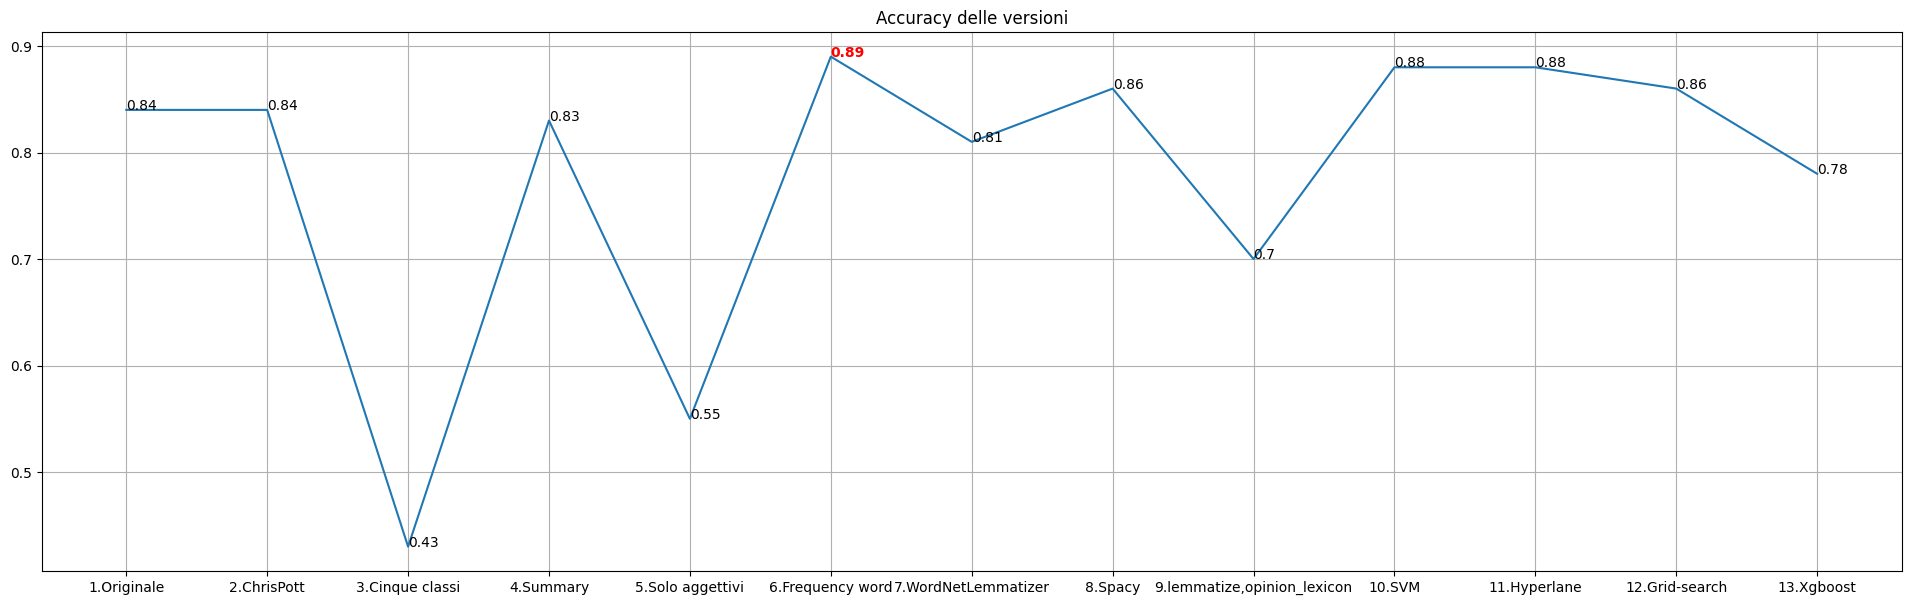

In [29]:
import matplotlib.pyplot as plt

x_titoli , y_accuracy = list(dizionario_plot.keys()), list(dizionario_plot.values())
plt.rcParams["figure.figsize"] = (24,7)

plt.plot(x_titoli, y_accuracy)
for i in range(len(x_titoli)):
    if y_accuracy[i] == max(y_accuracy):
        plt.text(x_titoli[i], y_accuracy[i], str(y_accuracy[i]), color="red", weight='bold')
    else:
        plt.text(x_titoli[i], y_accuracy[i], str(y_accuracy[i]))

plt.title('Accuracy delle versioni')
plt.grid()


In [27]:
print("con 1 run, il tempo totale e':", time.time()-inizioo_tempo) 

con 1 run, il tempo totale e': 329.39641880989075
